In [1]:
import patsy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv('credit_scoring.csv', parse_dates = ['data_ref'])

df['tempo_emprego'].fillna(-1, inplace=True)
df.head()

,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,1,F,True,True,0,Assalariado,Secundário,Casado,Casa,49,8.605479,2.0,1916.54,0
1,2015-01-01,2,M,True,False,0,Empresário,Secundário,União,Casa,60,6.953425,2.0,2967.25,0
2,2015-01-01,3,F,True,False,0,Empresário,Secundário,Casado,Casa,28,0.682192,2.0,340.96,0
3,2015-01-01,4,F,False,True,0,Assalariado,Superior completo,Casado,Casa,60,1.879452,2.0,4903.16,0
4,2015-01-01,5,F,False,False,0,Empresário,Secundário,Casado,Casa,47,8.438356,2.0,3012.60,0


#### Bases de desenvolvimento, validação e *out-of-time*

Vamos separar as bases que utilizaremos para desenvolver o modelo (train), *tunar* o modelo (test) e avaliar a performance (val).

In [3]:
# Selecionar meses de 2016 para validação
df_val = df[df['data_ref'] >= datetime(2016,1,1)].copy()

# Selecionar meses de 2015 para treinamento e teste
df = df[df['data_ref'] < datetime(2016,1,1)]

df_train, df_test = train_test_split(df, test_size=0.3, random_state=12)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print('Quantidade de linhas no treino:    ',df_train.shape[0])
print('Quantidade de linhas no teste:     ',df_test.shape[0])
print('Quantidade de linhas na validação: ',df_val.shape[0])

Quantidade de linhas no treino:     42000
Quantidade de linhas no teste:      18000
Quantidade de linhas na validação:  15000


In [4]:
equacao = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao 
            + estado_civil + tipo_residencia + idade + qt_pessoas_residencia'''
           
y_train, X_train = patsy.dmatrices(equacao, data=df_train)
y_test, X_test = patsy.dmatrices(equacao, data=df_test)
y_val, X_val = patsy.dmatrices(equacao, data=df_val)

## Métricas para problemas de classificação

Vamos avaliar o desempenho do random forest nas base de treinamento, teste e validação. Vamos avaliar a partir das seguintes métricas KS, Gini, AUC e Acurácia.

#### Função para calcular o desempenho

Para facilitar essas comparações, vamos construir uma função para calcular todos esses indicadores. É interessante colocar valores padrão para os parâmetros da função, assim, vamos poder indicar somente a base de dados para rodar a função com os valores padrão dela.

In [5]:
# Calcular o Gini
def calcula_gini(RESP, PD):
    #AUC
    auc = roc_auc_score(RESP, PD)
    
    #Gini
    gini = 2*auc -1
    return gini


def print_metricas(dados, 
                  PD = 'PD', 
                  CLASSE_PRED = 'classe_predita', 
                  RESP = 'mau'):
    
    #Acuracia
    acc = accuracy_score(dados[RESP], dados[CLASSE_PRED])

    #AUC
    auc = roc_auc_score(dados[RESP], dados[PD])
    
    #Gini
    gini = 2*auc-1
    
    #KS
    ks = ks_2samp(dados.loc[dados[RESP] == 1, PD], 
                  dados.loc[dados[RESP] != 1, PD]).statistic

    print('KS:       {0:.2f}%'.format(ks*100))
    print('AUC:      {0:.2f}%'.format(auc*100))
    print('GINI:     {0:.2f}%'.format(gini*100))
    print('Acurácia: {0:.2f}%\n'.format(acc*100))
    
    return None

## Random Forest no scikitlearn

In [6]:
%%time

clf = RandomForestClassifier(n_estimators=600, 
                             max_depth=13,
                             min_samples_leaf=41)

clf.fit(X_train,y_train.ravel())

df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:,1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:,1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:,1]

print_metricas(dados = df_train)
print_metricas(dados = df_test)
print_metricas(dados = df_val)

KS:       22.25%
AUC:      65.65%
GINI:     31.30%
Acurácia: 93.03%

KS:       16.00%
AUC:      60.53%
GINI:     21.06%
Acurácia: 93.16%

KS:       16.13%
AUC:      60.41%
GINI:     20.83%
Acurácia: 92.88%

CPU times: total: 23 s
Wall time: 23.3 s


# 2. Hiperparâmetros

Hiperparâmetros são parâmetros que controlam como o algoritmo é otimizado. O número de árvores por exemplo é um hiperparâmetro da *random forest*.

Qual é o melhor conjunto de hiperparâmetros para o *random forest*? Esta é a pergunta de ouro :) Mas felizmente há um método estruturado para se buscar esses hiperparâmetros, esse método é conhecido como *grid search* (ou busca em grade).

Vamos exemplificar essa busca de modo simplificado abaixo, buscando parâmetros um a um, em seguida variando mais de um ao longo de uma *grade* como o nome do método sugere.

### Iniciando a variação do número de árvores com for

In [7]:
%%time
lista_gini_test=[]
lista_gini_train=[]

grid = list(range(100, 1001, 150))

for num_arvores in grid:
    clf = RandomForestClassifier(n_estimators=num_arvores,
                                 max_depth=10,
                                 min_samples_leaf=5)
    
    clf.fit(X_train,y_train.ravel())
    
    gini_test  = calcula_gini(y_test, clf.predict_proba(X_test)[:,1])
    gini_train = calcula_gini(y_train, clf.predict_proba(X_train)[:,1])
    
    lista_gini_test.append(gini_test)
    lista_gini_train.append(gini_train)


CPU times: total: 1min 45s
Wall time: 1min 46s


{100: 0.3552239882893855, 250: 0.358204428281383, 400: 0.36189912356546605, 550: 0.3605655882035772, 700: 0.36203794023173064, 850: 0.3621108460873186, 1000: 0.36126290674317185}


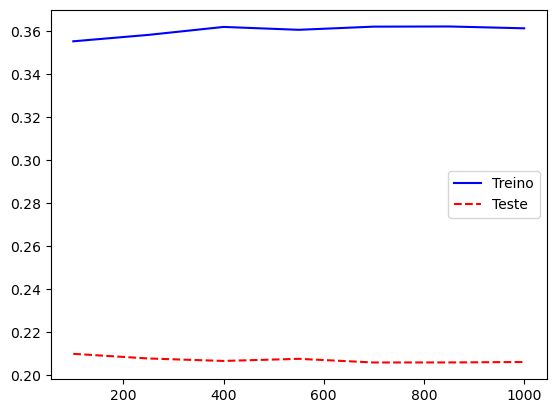

In [8]:
zip_gini_train = zip(list(range(100, 1001, 150)), lista_gini_train)
zip_gini_test = zip(list(range(100, 1001, 150)), lista_gini_test)

dict_gini_train = dict(zip_gini_train)
dict_gini_test = dict(zip_gini_test)
print(dict_gini_train)

series_gini_train = pd.Series(dict_gini_train)
series_gini_test = pd.Series(dict_gini_test)

#Plot comparando o gini no treino e no teste
fig, ax = plt.subplots()

ax.plot(series_gini_train, '-b', label='Treino')
ax.plot(series_gini_test,  '--r', label='Teste')

leg = ax.legend()

### Uma alternativa seria o RandomizedSearchCV

In [9]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

params = {
    'max_depth' : list(range(10,100,100)),
    'min_samples_leaf': list(range(2,1000,100)),
    'n_estimators': list(range(10,1000,100))
}

grid_rf = RandomizedSearchCV(n_iter = 7,
                             estimator = rf,
                             param_distributions = params,
                             scoring = 'accuracy', 
                             cv = 2)

grid_rf.fit(X_train, y_train.ravel())

CPU times: total: 1min 34s
Wall time: 1min 36s


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=7,
                   param_distributions={'max_depth': [10],
                                        'min_samples_leaf': [2, 102, 202, 302,
                                                             402, 502, 602, 702,
                                                             802, 902],
                                        'n_estimators': [10, 110, 210, 310, 410,
                                                         510, 610, 710, 810,
                                                         910]},
                   scoring='accuracy')

In [10]:
print(grid_rf.score(X_test, y_test))
grid_rf.best_params_

0.9316111111111111


{'n_estimators': 610, 'min_samples_leaf': 702, 'max_depth': 10}

## GridSearchCV -  1º tunning


In [11]:
%%time
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators = 510, 
                            min_samples_leaf = 902, 
                            max_depth = 10)

params = {
    'max_depth' : [8, 10, 12],
    'min_samples_leaf': [600, 800, 1000],
    'n_estimators': [300, 500, 700]
}

grid_rf = GridSearchCV(estimator = rf,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 3)

grid_rf.fit(X_train, y_train.ravel())

CPU times: total: 6min 49s
Wall time: 6min 56s


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=10,
                                              min_samples_leaf=902,
                                              n_estimators=510),
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_leaf': [600, 800, 1000],
                         'n_estimators': [300, 500, 700]},
             scoring='accuracy')

In [12]:
grid_rf.best_params_

{'max_depth': 8, 'min_samples_leaf': 600, 'n_estimators': 300}

## GridSearchCV -  2º tunning

In [13]:
%%time

rf = RandomForestClassifier(n_estimators = 300, 
                            min_samples_leaf = 600, 
                            max_depth = 8)

params = {
    'max_depth' : [8],
    'min_samples_leaf': [100, 300, 600],
    'n_estimators': [50, 100, 300]
}

grid_rf = GridSearchCV(estimator = rf,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 2)

grid_rf.fit(X_train, y_train.ravel())

CPU times: total: 27 s
Wall time: 27.4 s


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(max_depth=8, min_samples_leaf=600,
                                              n_estimators=300),
             param_grid={'max_depth': [8], 'min_samples_leaf': [100, 300, 600],
                         'n_estimators': [50, 100, 300]},
             scoring='accuracy')

In [14]:
grid_rf.best_params_

{'max_depth': 8, 'min_samples_leaf': 100, 'n_estimators': 50}

## GridSearchCV -  3º tunning

In [15]:
%%time

rf = RandomForestClassifier(n_estimators = 50, 
                            min_samples_leaf = 100, 
                            max_depth = 8)

params = {
    'max_depth' : [8],
    'min_samples_leaf': [25, 50, 100],
    'n_estimators': [25, 30, 50]
}

grid_rf = GridSearchCV(estimator = rf,
                        param_grid = params,
                        scoring = 'accuracy', 
                        cv = 2)

grid_rf.fit(X_train, y_train.ravel())

CPU times: total: 7.75 s
Wall time: 7.9 s


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(max_depth=8, min_samples_leaf=100,
                                              n_estimators=50),
             param_grid={'max_depth': [8], 'min_samples_leaf': [25, 50, 100],
                         'n_estimators': [25, 30, 50]},
             scoring='accuracy')

In [16]:
grid_rf.best_params_

{'max_depth': 8, 'min_samples_leaf': 25, 'n_estimators': 25}

# Modelo final após tunning

In [17]:
%%time

clf = RandomForestClassifier(n_estimators=25,
                                     max_depth=8,
                                     min_samples_leaf=25,
                                     n_jobs=-1)

clf.fit(X_train,y_train.ravel())

df_train['classe_predita'] = clf.predict(X_train)
df_train['PD'] = clf.predict_proba(X_train)[:,1]

df_test['classe_predita'] = clf.predict(X_test)
df_test['PD'] = clf.predict_proba(X_test)[:,1]

df_val['classe_predita'] = clf.predict(X_val)
df_val['PD'] = clf.predict_proba(X_val)[:,1]

print_metricas(dados = df_train)
print_metricas(dados = df_test)
print_metricas(dados = df_val)MN 

KS:       19.50%
AUC:      63.43%
GINI:     26.86%
Acurácia: 93.03%

KS:       17.02%
AUC:      60.31%
GINI:     20.62%
Acurácia: 93.16%

KS:       15.75%
AUC:      59.99%
GINI:     19.98%
Acurácia: 92.88%

CPU times: total: 1.88 s
Wall time: 595 ms
